In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points, evaluate_model
from parameterised_invariance_kernels import get_Polynomial_Invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [40]:
mean = zero_mean(2)
time_step = 0.1
training_time = 6
testing_time = 6

max_x = 150
n_train = 5
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

test_starting_position = np.random.uniform(-max_x, max_x)
test_starting_velocity = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position)
print(train_starting_velocity)

print(test_starting_position)
print(test_starting_velocity)

data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch
test_data = get_pendulum_data(time_step, testing_time, 1e-8, [test_starting_position], [test_starting_velocity])

for jitter in [2e-5]:
#    print("current jitter %s" %jitter)
    moi = get_GPR_model(get_MOI(), mean, data, 100)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
    evaluate_moi = evaluate_model(moi, test_data, time_step)
    print(evaluate_moi[:2])
    try:
        for poly_f_d in [2]:
            for poly_g_d in [4]:
                kernel = get_Polynomial_Invariance(3, 30, jitter, poly_f_d, poly_g_d) #switch
                m = get_GPR_model(kernel, mean, data, 1000)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_model(m, test_data, time_step)
                print(evaluate_invariance[:2])
                print(kernel.f_poly.numpy())
                print(kernel.g_poly.numpy())

    except tf.errors.InvalidArgumentError:
        print("jitter too small")
        continue
    except ValueError:
        print("jitter too small")
        continue

[ 127.67031104 -137.62033491   74.56134283  111.80415615    4.70477033]
[  4.17446942 -17.44158749 -27.05998839   3.42266787  11.00641748]
66.67374160232308
10.341054387008327
3261, 
(8.574219152445926e-09, 0.019899888287653253)
3265
(3.663031187186361e-08, 0.019930429751119423)
[[4.01823025e-06]
 [5.29814854e-03]]
[[-1.37045650e-06]
 [ 4.58887592e-03]
 [ 2.75830015e-07]
 [-5.02607441e-04]]


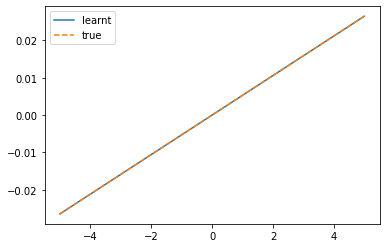

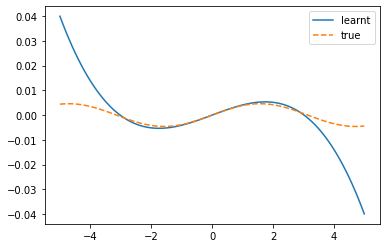

In [41]:
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-5,5,100)
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

plt.figure()
plt.plot(x, f(x), label='learnt')
plt.plot(x, kernel.f_poly.numpy()[1]*x, "--", label='true')
plt.legend()
plt.figure()
plt.plot(x, g(x), label='learnt')
plt.plot(x, kernel.g_poly.numpy()[1]*np.sin(x), "--", label='true')
plt.legend()

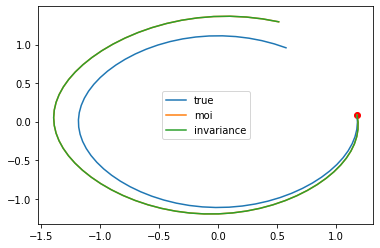

In [42]:
fig, ax = plt.subplots()
plt.plot(test_data[0][:,0],test_data[0][:,1], label="true")
plt.plot(evaluate_moi[2][:,0],evaluate_moi[2][:,1], label='moi')
plt.plot(evaluate_invariance[2][:,0],evaluate_invariance[2][:,1], label="invariance")
plt.scatter(test_data[0][0,0],test_data[0][0,1],color="red")
plt.legend()

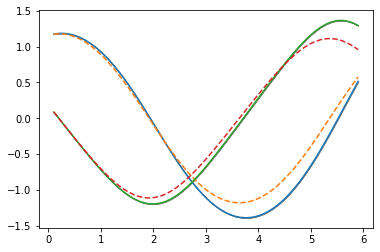

In [43]:
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
plt.plot(t,evaluate_moi[2][:,0])
plt.fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],'--')
plt.plot(t,evaluate_moi[2][:,1])
plt.fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,1],'--')

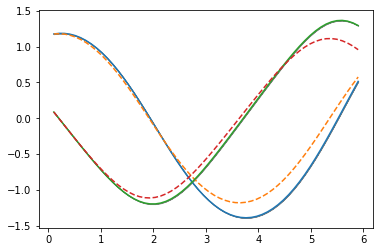

In [44]:
plt.plot(t,evaluate_invariance[2][:,0])
plt.fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],'--')
plt.plot(t,evaluate_invariance[2][:,1])
plt.fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,1],'--')